In [1]:
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random
import seaborn as sns
from fbprophet import Prophet
from dateutil.parser import parse

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the test data in memory
test_df = pd.read_csv("/content/drive/MyDrive/Maersk/test_data_maersk.csv")

# Time Series Modeling and prediction for data where ***Manufacturer*** = ***X2*** and ***Product Type*** = ***Powder*** and ***Sourcing Channel*** = ***RETAIL*** 

In [4]:
# Loading the training data in memory
df = pd.read_csv("/content/drive/MyDrive/Maersk/x2_powder_retail_outlier_removed_df.csv")
df.head()

,Month of Sourcing,Sourcing Cost
0,Nov-20,43.10
1,Nov-20,68.00
2,Nov-20,37.76
3,Nov-20,43.10
4,Nov-20,68.00


In [5]:
# Converting the Month of Sourcing data from strinf to datetime format for training
df["Month of Sourcing"] = df["Month of Sourcing"].str.replace('-','-20')
df["Month of Sourcing"]= df.apply(lambda x: parse(x['Month of Sourcing']),axis=1)
df.head()

,Month of Sourcing,Sourcing Cost
0,2020-11-25,43.10
1,2020-11-25,68.00
2,2020-11-25,37.76
3,2020-11-25,43.10
4,2020-11-25,68.00


In [6]:
# Ordering the training data by Month of Sourcing (oldest to newest)
data = df
data.sort_values(by=["Month of Sourcing"])

,Month of Sourcing,Sourcing Cost
22165,2020-07-25,3.48
22086,2020-07-25,0.00
22087,2020-07-25,5.65
22088,2020-07-25,46.59
22089,2020-07-25,23.43
...,...,...
4123,2021-05-25,28.58
4122,2021-05-25,73.28
4121,2021-05-25,26.94
4119,2021-05-25,64.06


(0.0, 500.0)

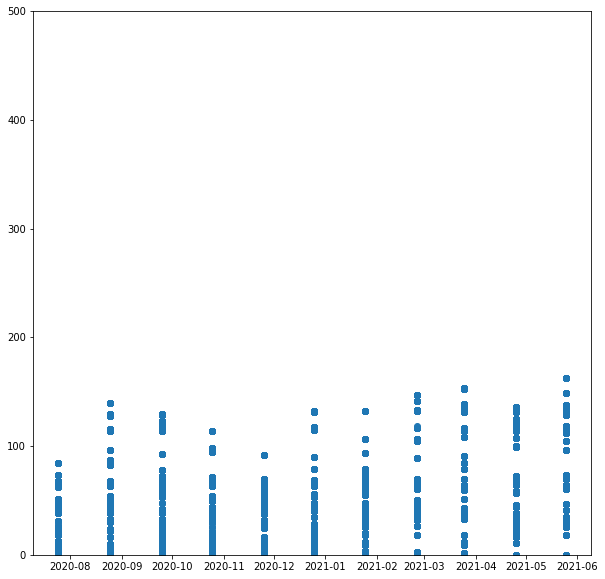

In [7]:
# Plottting the training data to visualize the scatter plot of the grouped time-series
plt.figure(figsize=(10,10))
plt.scatter(data["Month of Sourcing"], data["Sourcing Cost"])
plt.ylim((0,500))

In [8]:
# renaming the columns to symbolize the timestamp and the target
data = data.rename(columns={"Month of Sourcing":"ds", "Sourcing Cost":"y"})

In [9]:
# instantiating an object of Prophet Class (Using the Prophet Forecasting model developed by Facebook)
model = Prophet()
model.fit(data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
# Making prediction on the filtered data
test_df = test_df[(test_df["Manufacturer"]=="X2") & (test_df["Product Type"]=="Powder") & (test_df["Sourcing Channel"]=="RETAIL") ]
test_df["Month of Sourcing"] = test_df["Month of Sourcing"].str.replace('-','-20')
test_df["Month of Sourcing"]= test_df.apply(lambda x: parse(x['Month of Sourcing']),axis=1)
test_df.reset_index(drop=True,inplace=True)
test_df = test_df.rename(columns={"Month of Sourcing":"ds", "Sourcing Cost":"y"})

pred = model.predict(test_df[["ds"]])
pred = pred["yhat"].to_list()

test_df["yhat"] = pred

print(test_df)

  ProductType Manufacturer Area Code  ...         ds       y       yhat
0        NTM1           X2       A30  ... 2021-06-25   22.22  69.134146
1        NTM1           X2       A46  ... 2021-06-25   70.00  69.134146
2        NTM2           X2       A21  ... 2021-06-25  118.24  69.134146
3        NTM2           X2       A32  ... 2021-06-25   26.12  69.134146
4        NTM2           X2       A44  ... 2021-06-25   59.40  69.134146

[5 rows x 9 columns]


In [11]:
# Computing the Absolute Error in model's performance
diff_col = test_df["y"] - test_df["yhat"]
test_df["Absolute Error"] = diff_col
test_df["Absolute Error"]= test_df.apply(lambda x: abs(x["Absolute Error"]),axis=1)
print(test_df)

  ProductType Manufacturer Area Code  ...       y       yhat Absolute Error
0        NTM1           X2       A30  ...   22.22  69.134146      46.914146
1        NTM1           X2       A46  ...   70.00  69.134146       0.865854
2        NTM2           X2       A21  ...  118.24  69.134146      49.105854
3        NTM2           X2       A32  ...   26.12  69.134146      43.014146
4        NTM2           X2       A44  ...   59.40  69.134146       9.734146

[5 rows x 10 columns]


In [12]:
print("The mean absolute error in Sourcing Cost for this model's prediction is  " + str(test_df["Absolute Error"].mean()))

The mean absolute error in Sourcing Cost for this model's prediction is  29.926829102974615
